# <font size=6 id='data-preparation'>**DATA** **PREPARATION**</font>

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import opendatasets as od

In [6]:
telecom = 'https://www.kaggle.com/marcodena/mobile-phone-activity'

In [9]:
od.download(telecom)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username:

  bryanfozy


Your Kaggle Key:

  ········


 12%|█▏        | 29.0M/242M [00:31<03:53, 956kB/s] 


KeyboardInterrupt: 

In [2]:
#Load data
data_final = pd.read_csv('Data/csv/data_final.csv')
print("Load complete")

Load complete


In [3]:
type(data_final)

pandas.core.frame.DataFrame

Let's do time series data

A time series is a collection of digital data that is collected and recorded at regular time intervals. Each observation in a time series is associated with a specific instant in time, and observations are usually collected sequentially. Time series are used to study the evolution of a variable over time and to make predictions about the future values of the variable in question.

We will prepare our data for chronological forecasting, classification and anomaly detection.

In [4]:
def find_outliers(df, threshold=3):
    """
    This function detects the columns with the highest percentage of outliers and returns the percentage of outliers
    for each column.
    """
    outlier_cols = {}
    for col in df.columns:
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - threshold * iqr
        upper_bound = q3 + threshold * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        outlier_percentage = len(outliers) / len(df) * 100
        if outlier_percentage > 0:
            outlier_cols[col] = outlier_percentage
    sorted_outliers = sorted(outlier_cols.items(), key=lambda x: x[1], reverse=True)
    return sorted_outliers

In [5]:
columns_anomalies = find_outliers(data_final)

In [6]:
len(columns_anomalies)

9

array([[<AxesSubplot: title={'center': 'sent_explicit_withdraw'}>,
        <AxesSubplot: title={'center': 'messages_sent'}>,
        <AxesSubplot: title={'center': 'foreign_port'}>,
        <AxesSubplot: title={'center': 'sent_updates'}>],
       [<AxesSubplot: title={'center': 'sent_keepalives'}>,
        <AxesSubplot: title={'center': 'cpu_load_15min'}>,
        <AxesSubplot: title={'center': 'type_code'}>,
        <AxesSubplot: title={'center': 'sent_total_prefixes'}>],
       [<AxesSubplot: title={'center': 'messages_received'}>,
        <AxesSubplot: title={'center': 'sent_implicit_withdraw'}>,
        <AxesSubplot: title={'center': 'received_keepalives'}>,
        <AxesSubplot: title={'center': 'local_port'}>],
       [<AxesSubplot: title={'center': 'time'}>,
        <AxesSubplot: title={'center': 'compute_node_cpu_percent'}>,
        <AxesSubplot: title={'center': 'cpu_util_IntGW_01'}>,
        <AxesSubplot: title={'center': 'hardware_ipmi_temperature_cpu_2'}>],
       [<AxesSub

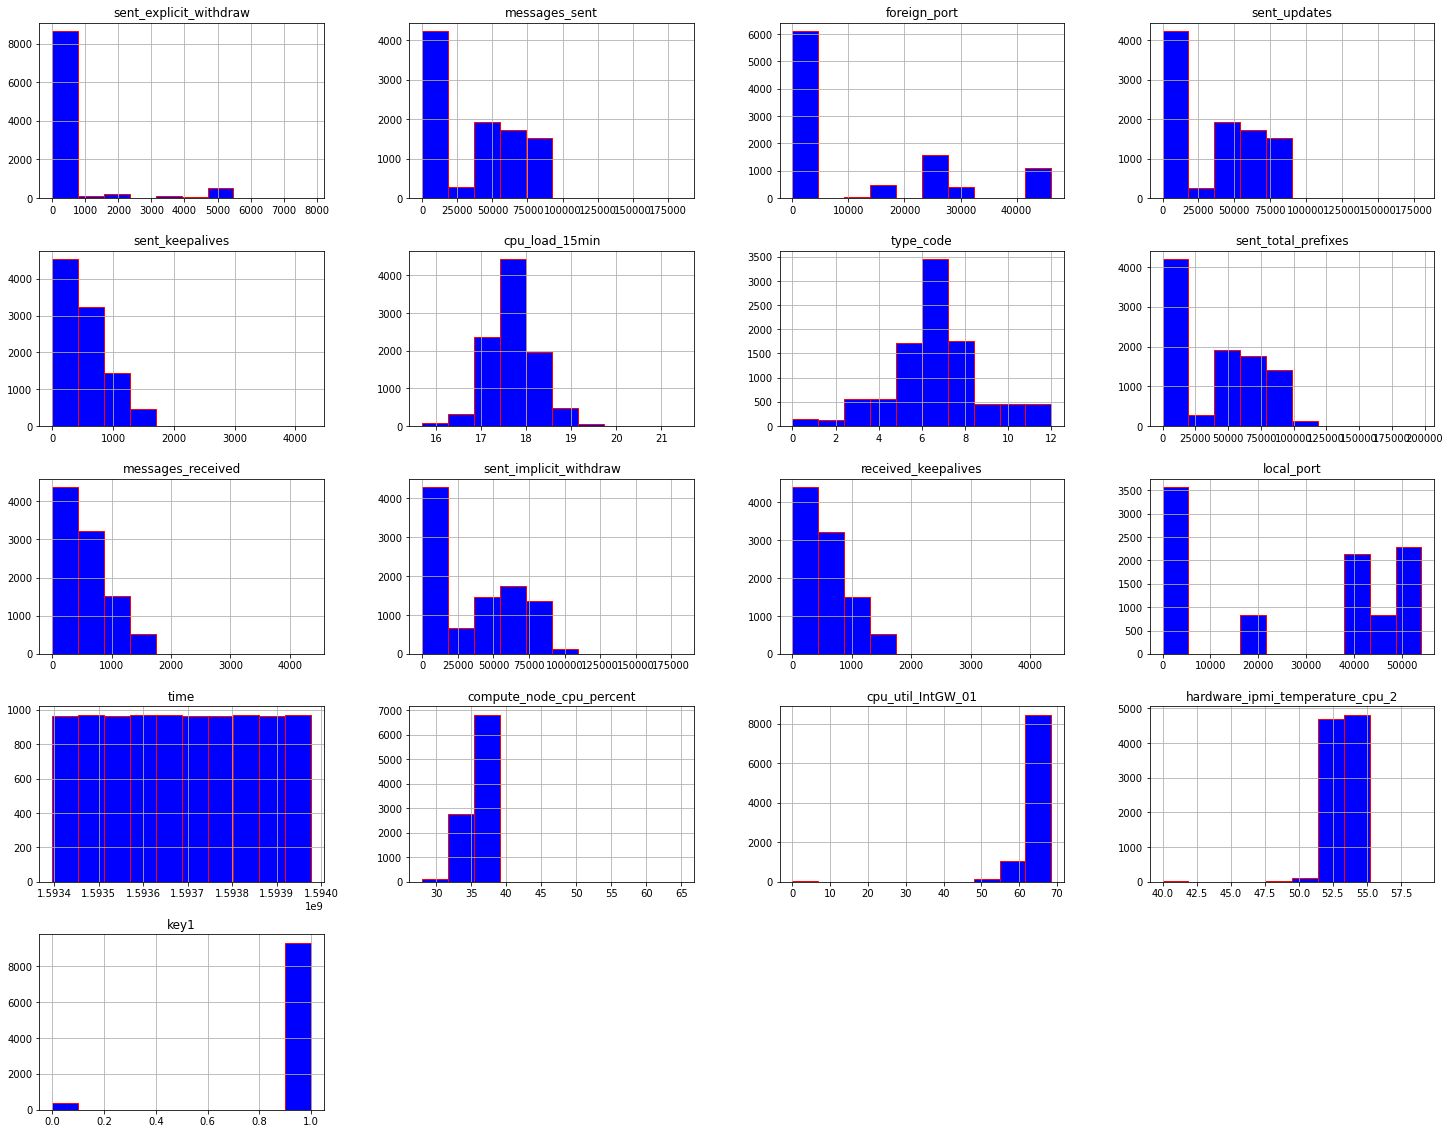

In [7]:
data_final.hist(bins=10, grid=True,figsize=(25,20), color="blue", edgecolor="red")

### ``` Observations:```

<p>We are on a problem of classification multi-classes and times series. So the approch to prepare our dataset will be different. It's important to know it.</p>
<p>Also we need to do detection of anomalies in the dataset.</p>

**Preprocessing**

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

#Split the data
X=data_final.drop('type_code', axis=1)
y=data_final['type_code']

seed=1111
x_train, x_valid, y_train, y_valid = train_test_split(X,y,test_size=0.2,random_state=seed,stratify=y)

In [9]:
#Frequency of the target
print("Frequency of classes on the target:")
y_train.value_counts(normalize=True)

Frequency of classes on the target:


8     0.181101
6     0.180455
7     0.176836
5     0.176448
4     0.057782
3     0.057782
10    0.047828
9     0.047182
12    0.023526
11    0.023526
1     0.013444
2     0.013444
0     0.000646
Name: type_code, dtype: float64

We have outliers in our dataset, so it's better to use Robust Scaler
$X=  \displaystyle\frac{X - Mediane}{InterQuartile}$


Unlike MinMaxScaler(), RobustScaler() is not based on the minimum and maximum values of the data but rather on quartiles, which makes it less sensitive to outliers.

In [10]:
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBClassifier


# Créer un pipeline avec MinMaxScaler et l'estimateur de votre choix
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', XGBClassifier(objective='multi:softmax'))
])


# Adapter le pipeline sur les données d'entraînement
pipeline.fit(x_train, y_train)

# Évaluer les performances du modèle sur les données de validation
score = pipeline.score(x_valid, y_valid)
print('Score:', score)

Score: 0.7936918304033092


In [12]:
from sklearn.linear_model import LogisticRegression

# Créer un pipeline avec MinMaxScaler et la régression logistique
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),
    ('estimator', LogisticRegression(multi_class='auto', solver='lbfgs', max_iter=1000))
])

# Adapter le pipeline sur les données d'entraînement
pipeline.fit(x_train, y_train)

# Évaluer la performance sur les données de validation
score = pipeline.score(x_valid, y_valid)
print(f"Score: {score:.3f}")

Score: 0.498
